In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

In [2]:
e0 = .25
ef = .01
s0 = 1e6
N = 41

G = 4*np.pi**2
sma = 45                 # semimajor axis in au
per = np.sqrt(sma**3)    # period in yr
frq = 1/per              # frequency in yr^-1
vkep = np.sqrt(G/sma) * (1.5e11/3.15e7)     # keplerian velocity in m s^-1

# Breaking energy law constants

A_stg = 2e7      # strength constant A in mJ (g m^2 / s^2)
B_stg = 3.3e-8   # strength constant B
s_small = 1e-2   # size_0 of strength eq = 1 cm
alp_stg = -0.3   # strength constant alpha
bet_stg = 2      # strength constant beta

def qstar(s1):
    term1 = A_stg * (s1/s_small)**alp_stg
    term2 = B_stg * 2.5 * (s1/s_small)**bet_stg
    return term1 + term2

def s2_break(s1,eccentricity):
    
    Q_ = qstar(s1) / 10000   # breaking energy in m^2 g / s^2
    omega = frq / (3.154e7)    # frequency in 1/s
    vcol = eccentricity*vkep
    denom = vcol**2 - 2*Q_
    s_ = 2*Q_ / denom
    
    size2 = s1*np.power(s_,1/3)
    return size2

def enew(s1, eccentricity):
    s2 = s2_break(s1,eccentricity)
    eps = eccentricity*np.sqrt(s1**6 + s2**6)/(s1**3+s2**3)
    return s2, eps

def epsilon(s1,eccentricity):
    s2 = s2_break(s1,eccentricity)
    eps = np.sqrt(s1**6 + s2**6)/(s1**3+s2**3)
    return s2, eps

def efault(s):
    """
    - For a given size, defines the minimum e for which a catastrophic collision can occur
    - Assumes both body and bullet have same e
    - If e < efail, 2*Q_star > vcol**2 --> not enough energy to break up
    
    In: s -- float; size, in meters
    Out: efail -- float; min eccentricity
    """
    Q_ = qstar(s)/10000
    efail = np.sqrt(2*Q_)/vkep
    return efail

# Maximum eccentricity

There is some initial eccentricity at which the drop off in eccentricity is not fast enough -- i.e. we get micron grains that still have high $e$. What is that eccentricity limit?

In [3]:
def ecc_evolve(s0,e0,ef):
    s = np.zeros(N)
    s2= np.zeros(N)
    s[0] = s0

    e = np.zeros(N)
    ep= np.zeros(N)
    e[0] = e0

    for i in range(N-1):
        s[i+1] = s[i]/2
        
    it = 0
    while it < N-1:
        size = s[it]
        ecc = e[it]
        s2[it], e[it+1] = enew(size,ecc)

        if e[it+1] < ef:
            e[it+2:] = np.nan
            break

        it += 1
        
    return e, s, s2, it

/var/folders/y4/2ycbkc7559gd7v34zsxpc8dh0000gn/T/ipykernel_54491/1307680944.py:33: RuntimeWarning: invalid value encountered in power
  size2 = s1*np.power(s_,1/3)
/var/folders/y4/2ycbkc7559gd7v34zsxpc8dh0000gn/T/ipykernel_54491/1307680944.py:33: RuntimeWarning: invalid value encountered in power
  size2 = s1*np.power(s_,1/3)
/var/folders/y4/2ycbkc7559gd7v34zsxpc8dh0000gn/T/ipykernel_54491/1307680944.py:33: RuntimeWarning: invalid value encountered in power
  size2 = s1*np.power(s_,1/3)


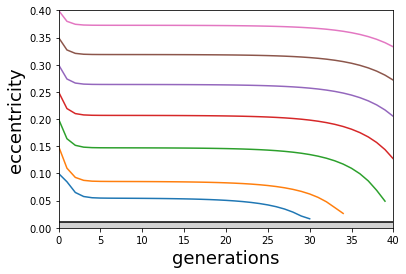

In [4]:
enaught = np.linspace(.1,.4,7)
for i in range(len(enaught)):
    e, s, s2, it = ecc_evolve(s0,enaught[i],ef)
    plt.plot(e,zorder=0)
plt.plot([0,N-1],[ef,ef],c='k')   
plt.fill_between([0,N-1],[0,0],[ef,ef],facecolor='lightgrey')
plt.ylabel('eccentricity',fontsize=18)
plt.xlabel('generations',fontsize=18)
plt.ylim(0,.4)
plt.xlim(0,N-1)
plt.show()

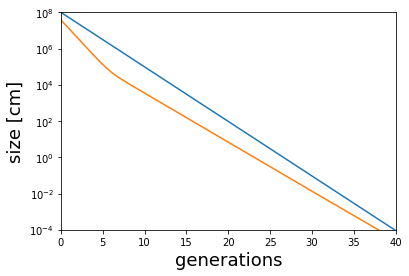

In [5]:
plt.plot(s*100)
plt.plot(s2*100)
plt.ylabel('size [cm]',fontsize=18)
plt.xlabel('generations',fontsize=18)
plt.ylim(1e-4,1e8)
plt.xlim(0,N-1)
plt.yscale('log')

## Characterizing $\varepsilon$ across $s-e$ space

In [6]:
gps = 300
gpe = 250

size_dist = np.logspace(-6,6,gps)
eccs_dist = np.linspace(0,.5,gpe)

ss, ee = np.meshgrid(size_dist,eccs_dist)

s2_grid, eps_grid = epsilon(ss,ee)

/var/folders/y4/2ycbkc7559gd7v34zsxpc8dh0000gn/T/ipykernel_54491/1307680944.py:33: RuntimeWarning: invalid value encountered in power
  size2 = s1*np.power(s_,1/3)


/var/folders/y4/2ycbkc7559gd7v34zsxpc8dh0000gn/T/ipykernel_54491/1307680944.py:33: RuntimeWarning: invalid value encountered in power
  size2 = s1*np.power(s_,1/3)
/var/folders/y4/2ycbkc7559gd7v34zsxpc8dh0000gn/T/ipykernel_54491/1307680944.py:33: RuntimeWarning: invalid value encountered in power
  size2 = s1*np.power(s_,1/3)


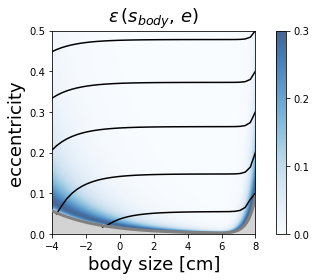

In [7]:
fig,ax = plt.subplots()
plt.imshow(1-eps_grid,origin='lower',extent=(-4,8,0,.5),
           aspect=24,vmax=.3,vmin=0,alpha=.75,cmap='Blues')
ax.set_facecolor('white')
enaught = np.linspace(.1,.5,5)
for i in range(len(enaught)):
    e, s, s2, it = ecc_evolve(s0,enaught[i],ef)
    plt.plot(np.log10(s*100),e,zorder=8,c='k')
plt.colorbar(ticks=[0,.1,.2,.3])
plt.plot(np.log10(size_dist*100),efault(size_dist),c='grey',lw=3,zorder=9)
plt.fill_between(np.log10(size_dist*100),np.zeros(gps),efault(size_dist),facecolor='lightgrey')
plt.title(r'$\varepsilon\,(s_{body},\,e)$',fontsize=18)
plt.xlabel('body size [cm]',fontsize=18)
plt.ylabel('eccentricity',fontsize=18)
plt.xlim(-4,8)
fig.tight_layout()
fig.savefig('an_se_evo.png',dpi=300)
plt.show()

/var/folders/y4/2ycbkc7559gd7v34zsxpc8dh0000gn/T/ipykernel_36549/2032771185.py:3: UserWarning: The following kwargs were not used by contour: 'c'
  plt.contour(s2_grid/size_dist,extent=(-4,8,0,.5),levels=[1],c='k')


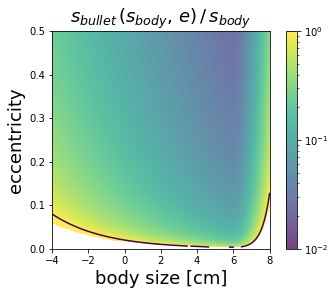

In [8]:
fig,ax = plt.subplots()
a = plt.imshow(s2_grid/size_dist,origin='lower',extent=(-4,8,0,.5),aspect=24,norm=LogNorm(vmin=1e-2,vmax=1),alpha=.75)
plt.contour(s2_grid/size_dist,extent=(-4,8,0,.5),levels=[1],c='k')
ax.set_facecolor('white')
plt.title(r'$s_{bullet}\,(s_{body},\,e)\,/\,s_{body}$',fontsize=18)
plt.xlabel('body size [cm]',fontsize=18)
plt.ylabel('eccentricity',fontsize=18)
plt.xlim(-4,8)
plt.colorbar(a)
plt.show()

As we can see, there are some combinations of sizes and eccentricities for which no bullet exists (at the same eccentricity) that is capable of breaking the bigger body. These are the grey sections. There are some starting eccentricities where the size breaks down too fast --- these will never reach a low enough eccentricity.

In [9]:
efs = np.zeros((gpe,N))
szs = np.zeros((gpe,N))
s2s = np.zeros((gpe,N))

for i in range(gpe):
    efs[i], szs[i], s2s[i], its = ecc_evolve(1e6,eccs_dist[i],.05)

/var/folders/y4/2ycbkc7559gd7v34zsxpc8dh0000gn/T/ipykernel_36549/1307680944.py:33: RuntimeWarning: invalid value encountered in power
  size2 = s1*np.power(s_,1/3)


In [10]:
e_min_s0 = efault(1e6)

/var/folders/y4/2ycbkc7559gd7v34zsxpc8dh0000gn/T/ipykernel_36549/3467776903.py:3: RuntimeWarning: All-NaN slice encountered
  plt.plot(eccs_dist,np.nanmin(efs[:,1:],axis=1),ls='',marker='o',c='C0',markersize=1)


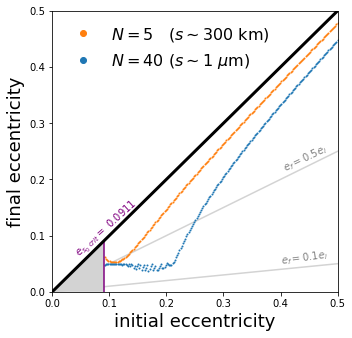

In [11]:
fig,ax=plt.subplots(figsize=(5,4.8))
plt.plot(eccs_dist,efs[:,5],ls='',marker='o',c='C1',markersize=1)
plt.plot(eccs_dist,np.nanmin(efs[:,1:],axis=1),ls='',marker='o',c='C0',markersize=1)
lgnd = plt.legend([r'$N = 5$   ($s\sim 300$ km)',
                   r'$N = 40$ ($s\sim 1$ $\mu$m)'],
                  frameon=False,fontsize=16)
lgnd.legendHandles[0].set_markersize(6)
lgnd.legendHandles[1].set_markersize(6)
plt.plot(eccs_dist,eccs_dist/2,c='lightgrey',zorder=0)
plt.plot(eccs_dist,eccs_dist/10,c='lightgrey',zorder=0)
plt.plot([0,.5],[0,.5],c='k',lw=3,zorder=9)
plt.plot([e_min_s0,e_min_s0],[0,e_min_s0],c='purple',zorder=8)
plt.fill_between([0,e_min_s0],[0,0],[0,e_min_s0],facecolor='lightgrey',zorder=0)
plt.ylim(0,.5)
plt.xlim(0,.5)
plt.xlabel('initial eccentricity',fontsize=18)
plt.ylabel('final eccentricity',fontsize=18)
plt.text(.4,.215,r'$e_f = 0.5e_i$',c='grey',rotation=90/(3.5))
plt.text(.4,.05, r'$e_f = 0.1e_i$',c='grey',rotation=7.8)
plt.text(e_min_s0-.055,.065,r'$e_{s_0\;crit}=$ %1.4f'%e_min_s0,c='purple',rotation=42)
fig.tight_layout()
fig.savefig('an_ecc_change_40gen.png',dpi=300)
plt.show()